# 1. Create a toy density

<IPython.core.display.Javascript object>


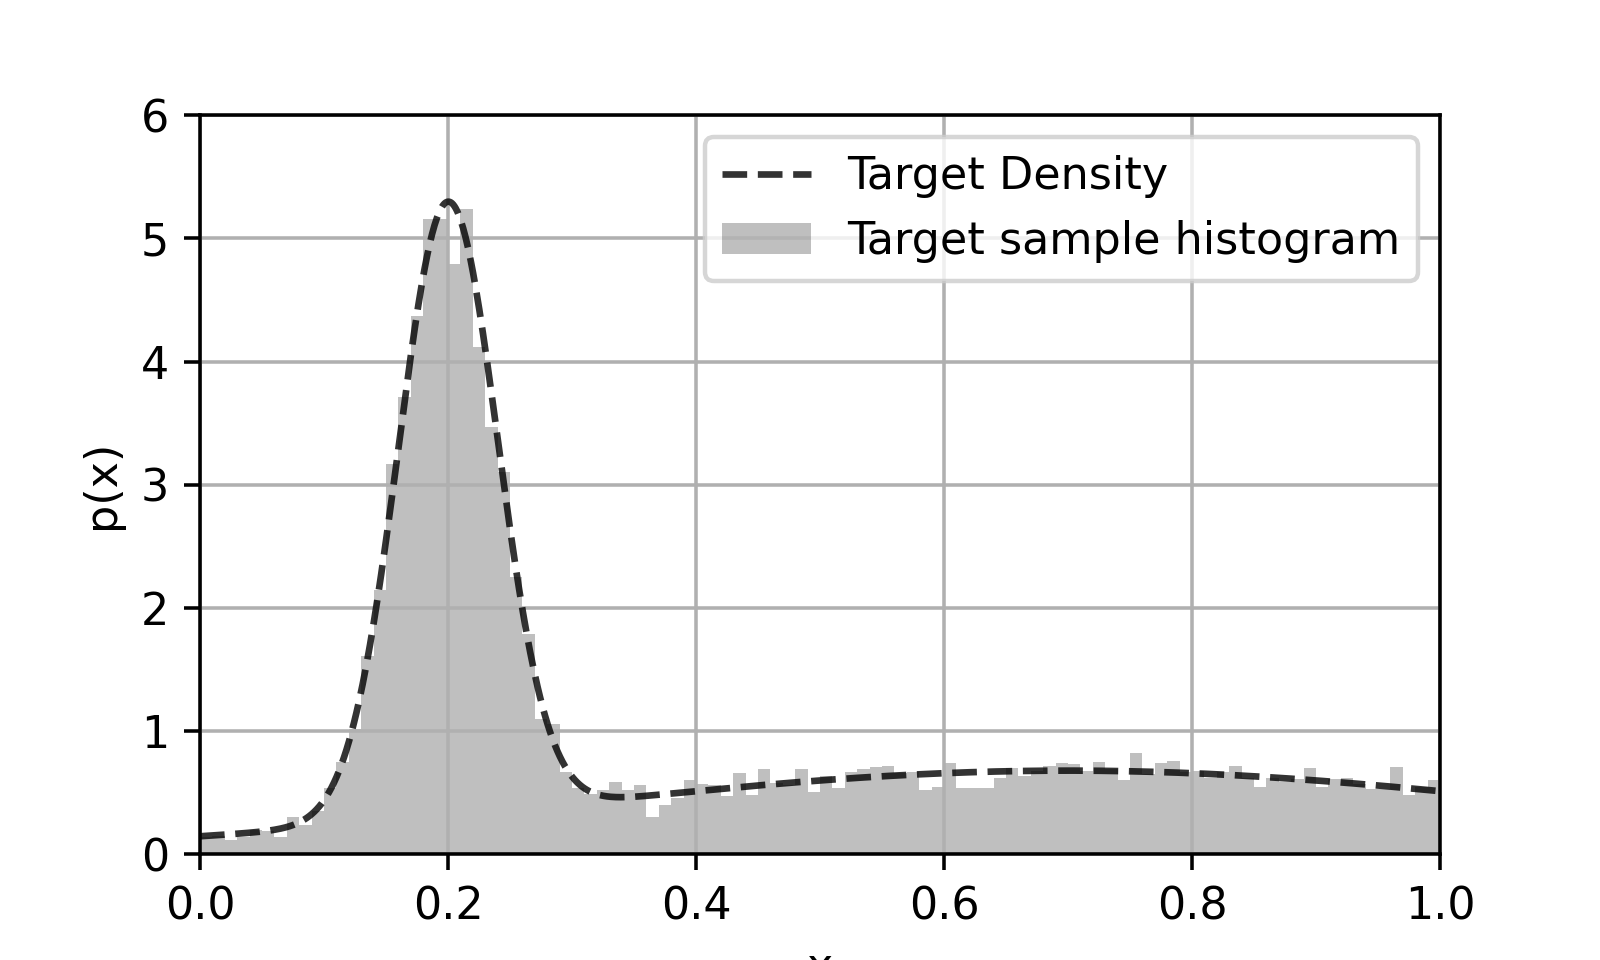

In [1]:
%matplotlib notebook

import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt

# create a mixture of two Truncated Gaussians with a support of [0, 1]
class TruncatedNormal:
    def __init__(self, mean, scale):
        self.mean = mean
        self.scale = scale

        self.d = Normal(mean, scale)

        self.l_cdf = self.d.cdf(torch.zeros_like(mean))
        self.r_cdf = self.d.cdf(torch.ones_like(mean))
        
        self.log_z = (self.r_cdf - self.l_cdf).log()

    def sample(self, shape):
        u = torch.rand(*shape, *self.mean.shape, device=self.mean.device) * (self.r_cdf - self.l_cdf) + self.l_cdf
        x = self.d.icdf(u)
        us = x.clamp(min=0., max=1.)
        return us

    def log_prob(self, x):
        return self.d.log_prob(x) - self.log_z

g1 = TruncatedNormal(torch.tensor(0.2), torch.tensor(0.04))
g2 = TruncatedNormal(torch.tensor(0.7), torch.tensor(0.4))

# sampling function
def sample_mixture(shape):
    s1, s2 = g1.sample(shape), g2.sample(shape)
    mask = (torch.rand(shape) < 0.5).float()
    return s1 * mask + s2 * (1. - mask)

# probability density computation
def compute_prob(x):
    return (g1.log_prob(x).exp() + g2.log_prob(x).exp()) / 2.


def visualize(ax, params=None):
    ax.clear()
    
    xs = torch.linspace(0., 1., 1000)
    if params is not None:
        q = Adacat(params)
        q_prob = q.log_prob(xs).exp().detach().numpy()
        qs = q.sample((10000,)).detach().numpy()
    
    p_prob = compute_prob(xs).detach().numpy()
    ps = sample_mixture((10000,)).numpy()
    
    ax.plot(xs, p_prob,    "--", color="black", alpha=0.80, label="Target Density")
    ax.hist(ps, range=(0., 1.), density=True, color="black", alpha=0.25, label="Target sample histogram", bins=100)

    if params is not None:
        ax.plot(xs, q_prob,    "-",  color="blue",  alpha=0.80, label="AdaCat analytic density")
        ax.hist(qs, range=(0., 1.), density=True, color="green", alpha=0.25, label="AdaCat sample histogram", bins=100)

    ax.set_ylim(0., 6.)
    ax.set_xlim(0., 1.)
    ax.set_ylabel("p(x)")
    ax.set_xlabel("x")
    ax.grid()
    ax.legend()

# let's visualize the target density
fig, ax = plt.subplots(figsize=(5, 3), dpi=160)
visualize(ax)

# 2. Define an Adacat distribution

<IPython.core.display.Javascript object>


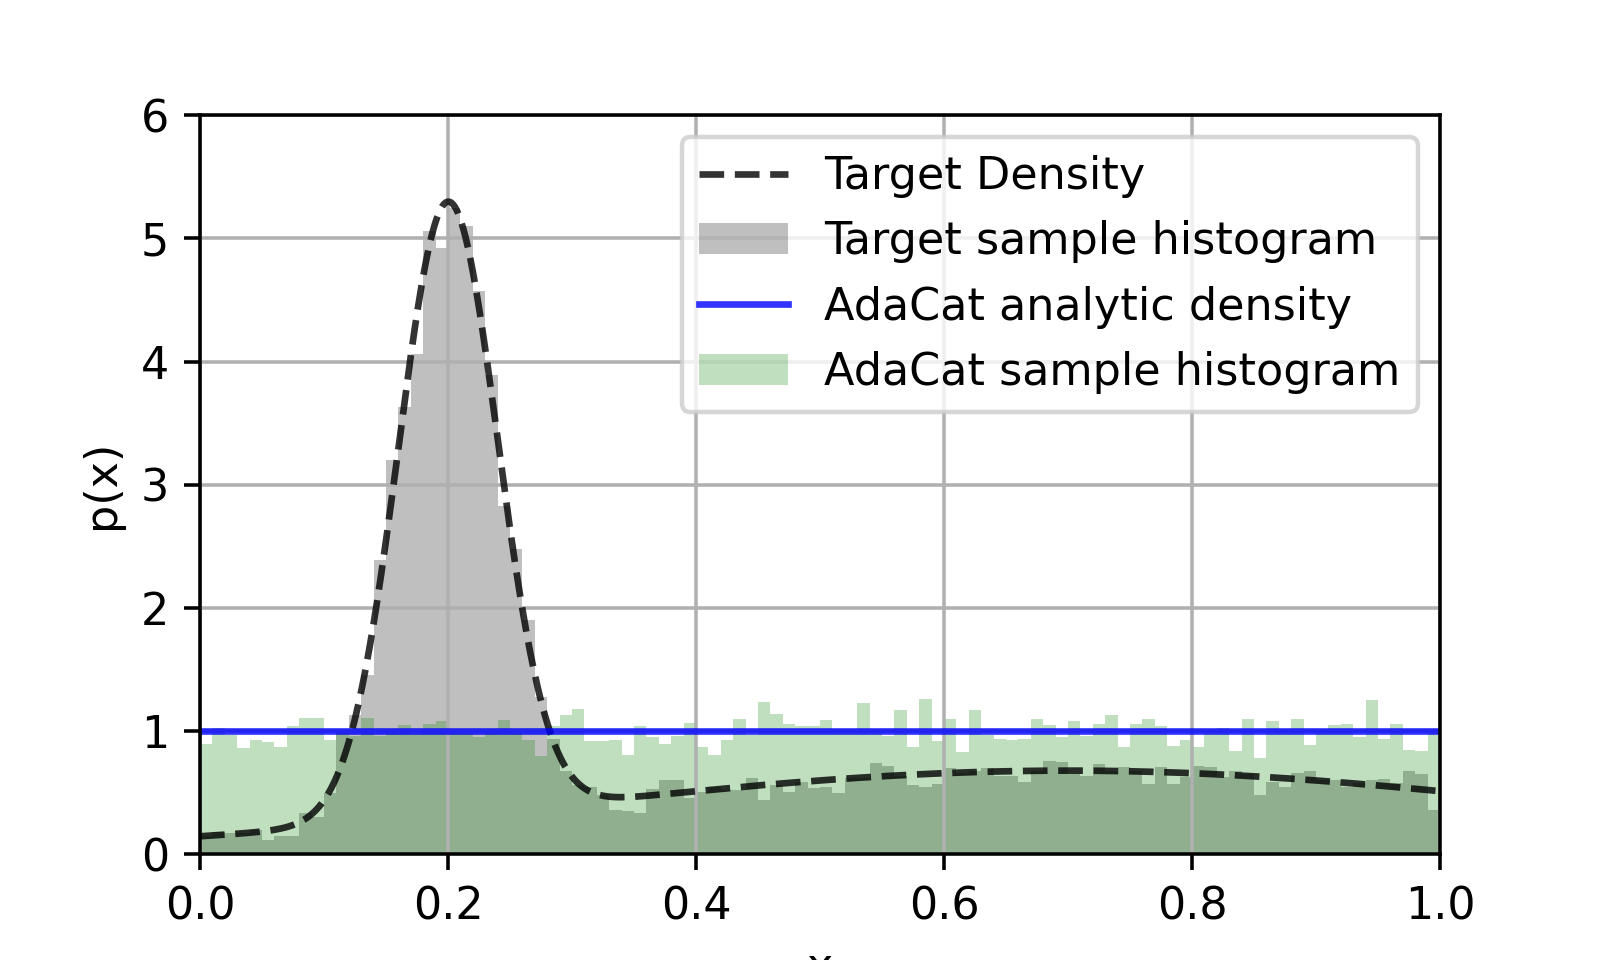

In [2]:
from adacat.torch import Adacat

# create parameters for the Adacat distribution and try to fit to the mixture of g1 and g2
k = 10  # use 10 components

params = torch.nn.Parameter(torch.zeros(k * 2))

fig, ax = plt.subplots(figsize=(5, 3), dpi=160)
visualize(ax, params)

# 3. Optimize the Adacat Distribution to Match the Toy Density

<IPython.core.display.Javascript object>


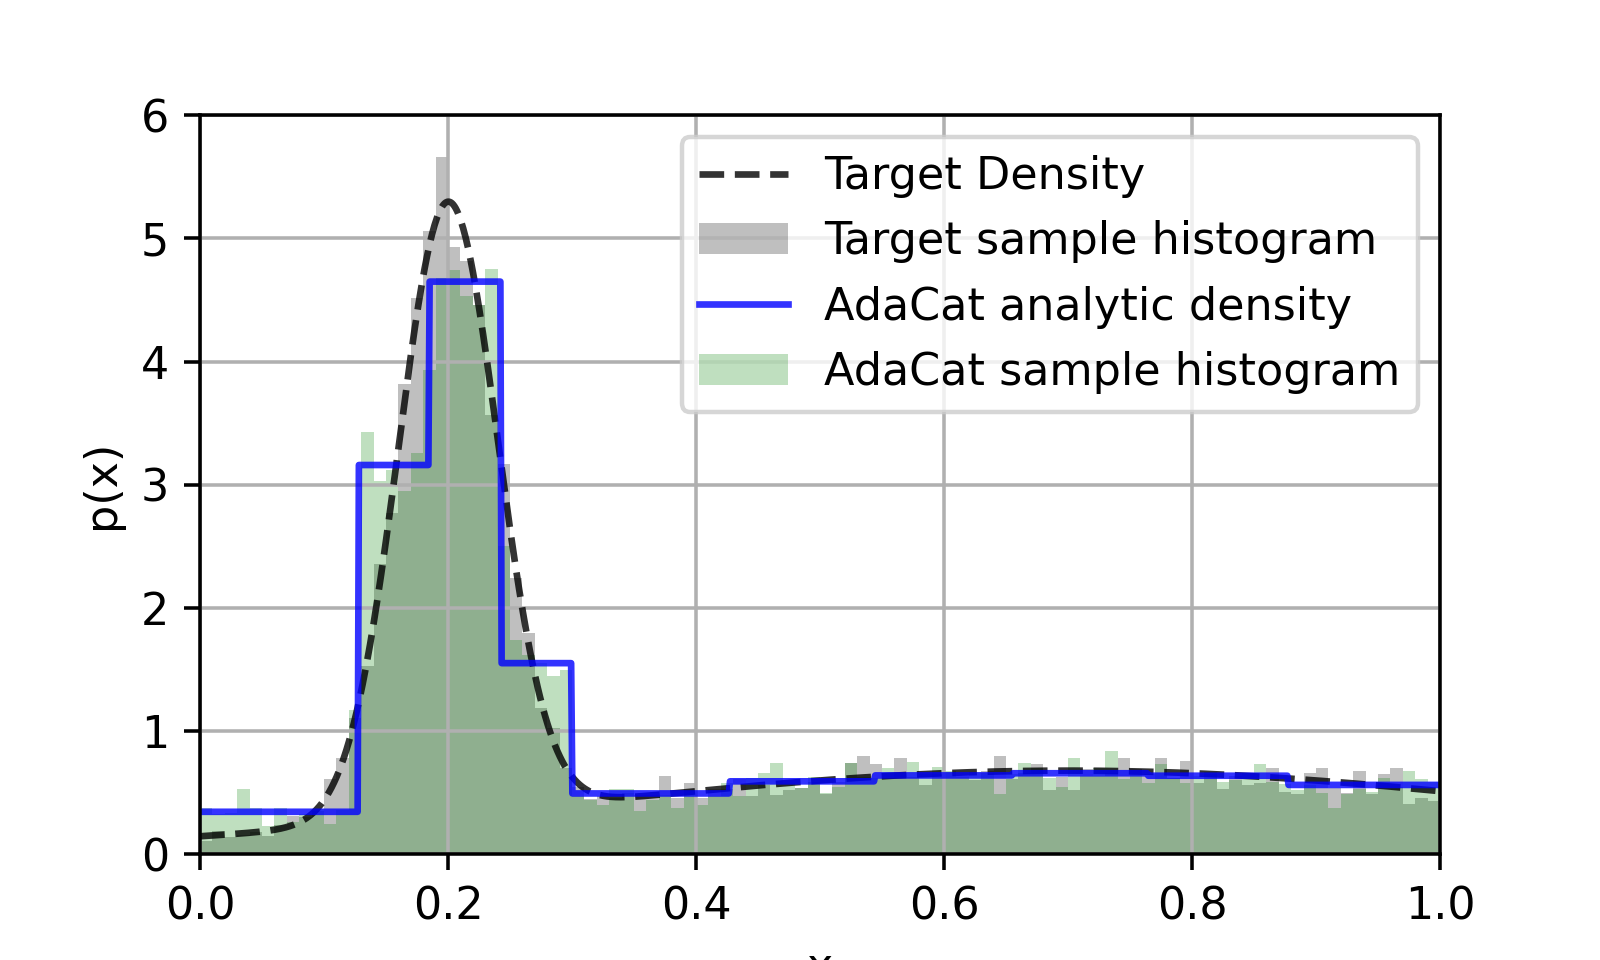

In [3]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=160)  # create a plot here. It will get updated when running the cell below.

In [4]:
optim = torch.optim.Adam([params], lr=0.001)
for _ in range(1, 3001):
    s = sample_mixture((200,)) # sample from the mixture data
    d = Adacat(params)
    loss = -d.log_prob(s, smooth_coeff=0.001).mean()  # smoothed loss
    optim.zero_grad()
    loss.backward()  # we optimize the smoothed loss
    optim.step()

    print("\rIt: {:05d}, \tsm_loss: {:.03f}".format(_, float(loss)), end="")
    
    if _ % 100 == 0: visualize(ax, params); fig.canvas.draw()
    
print("\nDone.")

It: 03000, 	sm_loss: -0.362
Done.
